<img src="a20_a21_a22_jaccard.svg" style="text-align:center;width:50%;display:inline;"><img src="a20_a21_a22_partial.svg" style="text-align:center;width:50%;display:inline;">

# Modifying phrases

### Modifying phrases properties:
* __prepositional phrases__ — Modify the subject, verb, or adjective
* __single word modifiers__ — adjectives and adverbs
* __multiplying and embedding modifiers__ — using multiple modification words and phrases within a single sentence


In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import utils
import importlib
import ast
from tqdm import tqdm
import re

In [2]:
importlib.reload(utils)
connection = utils.connectDB()

In [3]:
FEATURE = "Modifying_phrases"

In [4]:
# IMPORTANT: GPT data was corrected. Read the corrected GPT sheet NOT the database
gpt_df = pd.read_csv("corrected_GPT_min.csv")

In [5]:
# When this data is read in the majority_prop Type is incomaptible with the script downstream, so we just recreate this column each time
gpt_df['majority_prop'] = [list(utils.find_majority(ast.literal_eval(l))[0]) for l in gpt_df['all_properties']]

In [6]:
gpt_df.head()

,sentence_id,all_properties,feature_id,majority_prop
0,265,"[{'simple'}, {'simple'}, {'simple'}, {'simple'...",Aspect,[simple]
1,265,"[{'indicative'}, {'indicative'}, {'indicative'}]",Mood,[indicative]
2,265,[],Verb_choices,[]
3,265,"[{'subordinate'}, {'subordinate', 'adjective'}...",Modifying_clauses,"[adjective, subordinate]"
4,265,"[{'multiplying and embedding modifiers', 'sing...",Modifying_phrases,"[multiplying and embedding modifiers, single w..."


In [7]:
query = 'select * from annotations where annotator_id in (20,21,22) and completed=1;'
annotations = pd.read_sql(query, connection)

/Users/kylehamilton/opt/anaconda3/envs/annotation/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


### Format the human annotations like GPT for making comaprisons
This will roll the annotations up to the sentence level

In [8]:
a_20 = utils.annotationsToGPTFormat(20,annotations)
a_21 = utils.annotationsToGPTFormat(21,annotations)
a_22 = utils.annotationsToGPTFormat(22,annotations)

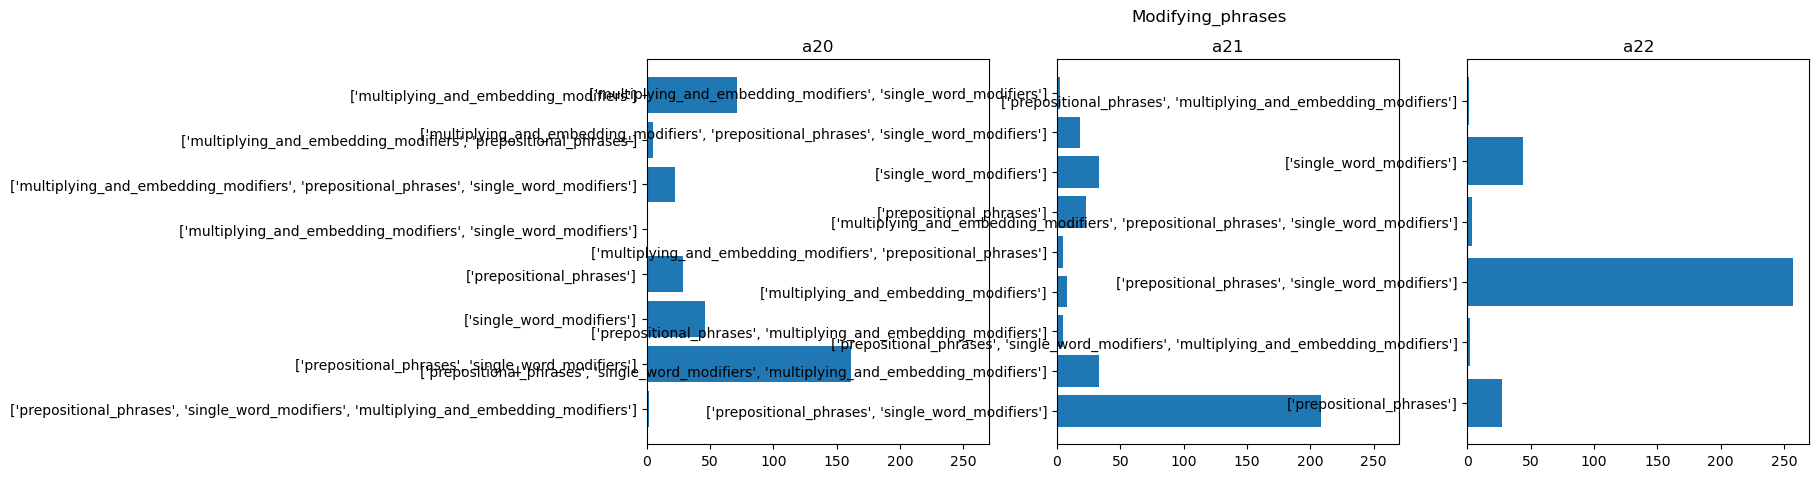

In [9]:
utils.plotPropertyDistributions(FEATURE,a_20,a_21,a_22)

In [10]:
features_gpt = list(gpt_df.groupby('feature_id').agg(list).reset_index()['feature_id'])
idx_gpt = features_gpt.index(FEATURE)
gpt_df_properties = gpt_df.groupby('feature_id').agg(list).reset_index().loc[idx_gpt][['all_properties','sentence_id']]
cGPT = Counter([str(utils.find_majority(ast.literal_eval(l))[0]) for l in gpt_df_properties['all_properties']])

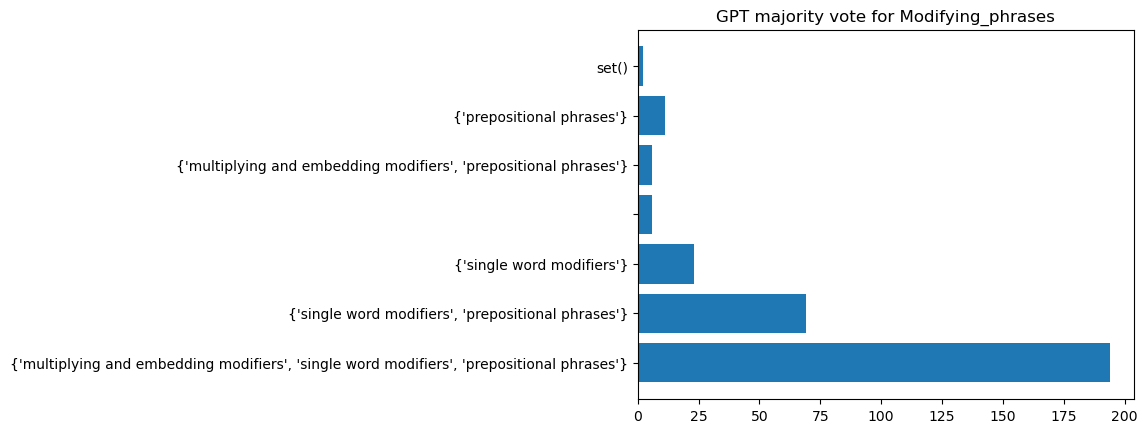

In [11]:
plt.barh(list(cGPT.keys()),list(cGPT.values()))
plt.title("GPT majority vote for "+FEATURE)
plt.show()

### Find all the sentences where there is agreement on the majority property

In [12]:
majority_property = ''

### Find all the sentences (and the respective annotations) that are not in the agreed sentences list

### Find all sentences

In [12]:
query = 'SELECT id, technique, text FROM ebdb.sample_sentences;'
non_agreed_sentences = pd.read_sql(query, connection)

/Users/kylehamilton/opt/anaconda3/envs/annotation/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [13]:
non_agreed_sentences['feature_id'] = FEATURE
non_agreed_sentences['props_a20'] = ''
non_agreed_sentences['props_a21'] = ''
non_agreed_sentences['props_a22'] = ''
non_agreed_sentences['props_gpt'] = ''

In [14]:
non_agreed_sentences = non_agreed_sentences[['id', 'technique', 'text', 'feature_id', 'props_a20', 'props_a21', 'props_a22', 'props_gpt']]
non_agreed_sentences = non_agreed_sentences.rename(columns={'id':'sentence_id'})

In [15]:
print(len(non_agreed_sentences))
non_agreed_sentences.head()

357


,sentence_id,technique,text,feature_id,props_a20,props_a21,props_a22,props_gpt
0,4,[0 8 9],"Muhammad advises the same thing, according to ...",Modifying_phrases,,,,
1,11,[0 8],We are simply asked to take the pope’s word fo...,Modifying_phrases,,,,
2,14,[0],Conservative Ben Shapiro told Fox news the ver...,Modifying_phrases,,,,
3,16,[0],"According to Breitbart, “Sellner, who describe...",Modifying_phrases,,,,
4,23,[0],“This is a clear violation of the Senate Ethic...,Modifying_phrases,,,,


In [16]:
utils.fillInAnnotations(non_agreed_sentences,a_20,a_21,a_22,gpt_df,FEATURE)

,sentence_id,technique,text,feature_id,props_a20,props_a21,props_a22,props_gpt
0,4,[0 8 9],"Muhammad advises the same thing, according to ...",Modifying_phrases,"[prepositional_phrases, single_word_modifiers,...","[prepositional_phrases, single_word_modifiers]",[prepositional_phrases],
1,11,[0 8],We are simply asked to take the pope’s word fo...,Modifying_phrases,"[prepositional_phrases, single_word_modifiers]","[prepositional_phrases, single_word_modifiers,...",[prepositional_phrases],
2,14,[0],Conservative Ben Shapiro told Fox news the ver...,Modifying_phrases,[single_word_modifiers],,,
3,16,[0],"According to Breitbart, “Sellner, who describe...",Modifying_phrases,[prepositional_phrases],"[prepositional_phrases, multiplying_and_embedd...","[prepositional_phrases, single_word_modifiers,...",
4,23,[0],“This is a clear violation of the Senate Ethic...,Modifying_phrases,"[multiplying_and_embedding_modifiers, single_w...","[prepositional_phrases, single_word_modifiers]","[prepositional_phrases, single_word_modifiers]",
...,...,...,...,...,...,...,...,...
352,14484,[],"They noted Haig's LinkedIn page, which says he...",Modifying_phrases,[multiplying_and_embedding_modifiers],"[prepositional_phrases, single_word_modifiers]","[prepositional_phrases, single_word_modifiers]","[multiplying and embedding modifiers, single w..."
353,14506,[],"When asked about the threats, Haig said, “I’ve...",Modifying_phrases,"[prepositional_phrases, single_word_modifiers]","[prepositional_phrases, single_word_modifiers]","[prepositional_phrases, single_word_modifiers]","[multiplying and embedding modifiers, single w..."
354,14878,[],"In 1953, the CIA was in the process of develop...",Modifying_phrases,[multiplying_and_embedding_modifiers],"[prepositional_phrases, single_word_modifiers]","[prepositional_phrases, single_word_modifiers]","[multiplying and embedding modifiers, single w..."
355,15168,[],"“If code is speech, the constitutional contrad...",Modifying_phrases,"[prepositional_phrases, single_word_modifiers]","[prepositional_phrases, single_word_modifiers]","[prepositional_phrases, single_word_modifiers]","[multiplying and embedding modifiers, single w..."


In [17]:
non_agreed_sentences.to_csv("non_agreed_sentences_"+FEATURE+".csv",index=None)

### Find rows with missing GPT responses

In [18]:
to_reprompt = non_agreed_sentences[non_agreed_sentences['props_gpt']=='']

In [19]:
print(len(to_reprompt))
to_reprompt.head()

46


,sentence_id,technique,text,feature_id,props_a20,props_a21,props_a22,props_gpt
0,4,[0 8 9],"Muhammad advises the same thing, according to ...",Modifying_phrases,"[prepositional_phrases, single_word_modifiers,...","[prepositional_phrases, single_word_modifiers]",[prepositional_phrases],
1,11,[0 8],We are simply asked to take the pope’s word fo...,Modifying_phrases,"[prepositional_phrases, single_word_modifiers]","[prepositional_phrases, single_word_modifiers,...",[prepositional_phrases],
2,14,[0],Conservative Ben Shapiro told Fox news the ver...,Modifying_phrases,[single_word_modifiers],,,
3,16,[0],"According to Breitbart, “Sellner, who describe...",Modifying_phrases,[prepositional_phrases],"[prepositional_phrases, multiplying_and_embedd...","[prepositional_phrases, single_word_modifiers,...",
4,23,[0],“This is a clear violation of the Senate Ethic...,Modifying_phrases,"[multiplying_and_embedding_modifiers, single_w...","[prepositional_phrases, single_word_modifiers]","[prepositional_phrases, single_word_modifiers]",


### Reprompt GPT 3 times and merge with non_agreed_sentences

In [24]:
# model = "gpt-3.5-turbo-0301"
# model = "gpt-3.5-turbo-0613"
# model = "gpt-3.5-turbo-1106"
# model = "gpt-4"

In [20]:
import GPT
importlib.reload(GPT)

<module 'GPT' from '/Users/kylehamilton/MyDocuments/ML-Labs/annotation-app/rhetoric-annotation/results/GPT.py'>

In [27]:
def parseRes(x):
    try:
        result = utils.parseGPTresponse(x)[1][0]
    except:
        result = []
    return result

for i in range(1,2):
    responses = []
    gpt = GPT.GPT("gpt-3.5-turbo-1106")

    for row in tqdm(to_reprompt.iterrows()):
        sentence = row[1]['text']
        feature = row[1]['feature_id']
        sid = row[1]['sentence_id']
        promt, response = gpt.get_gpt_response(sentence,feature,sid)
        responses.append([sid, response])

    df = pd.DataFrame(responses, columns=['sentence_id','res'+str(i)])
    df['gpt_props'+str(i)] = df['res'+str(i)].apply(parseRes)
    non_agreed_sentences = non_agreed_sentences.merge(df, how='outer',on='sentence_id')
    non_agreed_sentences.to_csv("non_agreed_sentences_"+FEATURE+".csv",index=None)

    print(f"There were {len(gpt.errors)} errors in round {i}.")

46it [20:12, 26.35s/it] 

There were 3 errors in round 1.


In [28]:
# Sanity check
non_agreed_sentences = pd.read_csv("non_agreed_sentences_"+FEATURE+".csv")
print(len(non_agreed_sentences))
non_agreed_sentences.head()

357


,sentence_id,technique,text,feature_id,props_a20,props_a21,props_a22,props_gpt,res2,gpt_props2,res3,gpt_props3,res1,gpt_props1
0,4,[0 8 9],"Muhammad advises the same thing, according to ...",Modifying_phrases,"['prepositional_phrases', 'single_word_modifie...","['prepositional_phrases', 'single_word_modifie...",['prepositional_phrases'],NaN,"{\n ""Properties"": [\n ""prepositional phras...",[],"{\n ""Properties"": [""prepositional phrases"", ""...","['prepositional phrases', 'single word modifie...","{\n ""Properties"": [""prepositional phrases"", ""...","['prepositional phrases', 'single word modifie..."
1,11,[0 8],We are simply asked to take the pope’s word fo...,Modifying_phrases,"['prepositional_phrases', 'single_word_modifie...","['prepositional_phrases', 'single_word_modifie...",['prepositional_phrases'],NaN,"{\n ""Properties"": [\n ""prepositional phras...",[],"{\n ""Properties"": [""prepositional phrases"", ""...","['prepositional phrases', 'single word modifie...","{\n ""Properties"": [""prepositional phrases"", ""...","['prepositional phrases', 'single word modifie..."
2,14,[0],Conservative Ben Shapiro told Fox news the ver...,Modifying_phrases,['single_word_modifiers'],NaN,NaN,NaN,timeout,[],"{\n ""Properties"": [""single word modifiers""],\...",['single word modifiers'],"{\n ""Properties"": [""single word modifiers""],\...",['single word modifiers']
3,16,[0],"According to Breitbart, “Sellner, who describe...",Modifying_phrases,['prepositional_phrases'],"['prepositional_phrases', 'multiplying_and_emb...","['prepositional_phrases', 'single_word_modifie...",NaN,"{\n ""Properties"": [""prepositional phrases"", ""...","['prepositional phrases', 'single word modifie...","{\n ""Properties"": [\n ""prepositional phras...",[],timeout,[]
4,23,[0],“This is a clear violation of the Senate Ethic...,Modifying_phrases,"['multiplying_and_embedding_modifiers', 'singl...","['prepositional_phrases', 'single_word_modifie...","['prepositional_phrases', 'single_word_modifie...",NaN,"{\n ""Properties"": [\n ""prepositional phras...",[],"{\n ""Properties"": [""prepositional phrases"", ""...","['prepositional phrases', 'single word modifie...","{\n ""Properties"": [\n ""prepositional phras...",[]


In [29]:
# get the majority vote from the annotators (props_a20, props_a21, props_a22)

# What to do when there is no majority? NA?


non_agreed_sentences['props_a_majority'] = non_agreed_sentences['props_a20']+", "+\
                                           non_agreed_sentences['props_a21']+", "+\
                                           non_agreed_sentences['props_a22'] #.apply(utils.find_majority)

def convert(x):
    try: result = list(ast.literal_eval(x))
    except: result = [[]]
    return result

non_agreed_sentences['props_a_majority'] = non_agreed_sentences['props_a_majority'].apply(convert)
non_agreed_sentences['props_a_majority'] = non_agreed_sentences['props_a_majority'].apply(lambda l: utils.find_majority(l)[0])

In [30]:
# get the majority vote from the reprompt (gpt_props1, gpt_props2, gpt_props3)

non_agreed_sentences['props_gpt_majority'] = non_agreed_sentences['gpt_props1']+", "+\
                                           non_agreed_sentences['gpt_props2']+", "+\
                                           non_agreed_sentences['gpt_props3'] #.apply(utils.find_majority)

def convert(x):
    try: result = list(ast.literal_eval(x))
    except: result = [[]]
    return result

non_agreed_sentences['props_gpt_majority'] = non_agreed_sentences['props_gpt_majority'].apply(convert)
non_agreed_sentences['props_gpt_majority'] = non_agreed_sentences['props_gpt_majority'].apply(lambda l: utils.find_majority(l)[0])

In [31]:
# Merge the previous gpt props with the newly reprompted ones into a single column
def convert(x):
    try: 
        result = list(ast.literal_eval(x))
        result = [r.replace(" ","_") for r in result]
    except: 
        result = []
    return result

non_agreed_sentences['props_gpt'] = non_agreed_sentences['props_gpt'].apply(convert)
non_agreed_sentences['props_gpt_majority'] = non_agreed_sentences['props_gpt_majority'] + non_agreed_sentences['props_gpt']
non_agreed_sentences = non_agreed_sentences.drop(['props_gpt'], axis=1)


### Calculate agreement between annotator majority and GPT majority

One issue is that when there is no majority the last item is selected

In [32]:
non_agreed_sentences['ann_gpt_agreemnt'] = non_agreed_sentences.apply(lambda x: utils.calcAgreement(x['props_a_majority'],x['props_gpt_majority']), axis=1)

In [33]:
# save the final version
non_agreed_sentences.to_csv("non_agreed_sentences_"+FEATURE+".csv",index=None)

In [34]:
# Sanity check
non_agreed_sentences = pd.read_csv("non_agreed_sentences_"+FEATURE+".csv")
print(len(non_agreed_sentences))
non_agreed_sentences.head()

357


,sentence_id,technique,text,feature_id,props_a20,props_a21,props_a22,res2,gpt_props2,res3,gpt_props3,res1,gpt_props1,props_a_majority,props_gpt_majority,ann_gpt_agreemnt
0,4,[0 8 9],"Muhammad advises the same thing, according to ...",Modifying_phrases,"['prepositional_phrases', 'single_word_modifie...","['prepositional_phrases', 'single_word_modifie...",['prepositional_phrases'],"{\n ""Properties"": [\n ""prepositional phras...",[],"{\n ""Properties"": [""prepositional phrases"", ""...","['prepositional phrases', 'single word modifie...","{\n ""Properties"": [""prepositional phrases"", ""...","['prepositional phrases', 'single word modifie...","['prepositional_phrases', 'single_word_modifie...","['prepositional phrases', 'single word modifie...",-1
1,11,[0 8],We are simply asked to take the pope’s word fo...,Modifying_phrases,"['prepositional_phrases', 'single_word_modifie...","['prepositional_phrases', 'single_word_modifie...",['prepositional_phrases'],"{\n ""Properties"": [\n ""prepositional phras...",[],"{\n ""Properties"": [""prepositional phrases"", ""...","['prepositional phrases', 'single word modifie...","{\n ""Properties"": [""prepositional phrases"", ""...","['prepositional phrases', 'single word modifie...","['prepositional_phrases', 'single_word_modifie...","['prepositional phrases', 'single word modifie...",-1
2,14,[0],Conservative Ben Shapiro told Fox news the ver...,Modifying_phrases,['single_word_modifiers'],NaN,NaN,timeout,[],"{\n ""Properties"": [""single word modifiers""],\...",['single word modifiers'],"{\n ""Properties"": [""single word modifiers""],\...",['single word modifiers'],[],['single word modifiers'],-1
3,16,[0],"According to Breitbart, “Sellner, who describe...",Modifying_phrases,['prepositional_phrases'],"['prepositional_phrases', 'multiplying_and_emb...","['prepositional_phrases', 'single_word_modifie...","{\n ""Properties"": [""prepositional phrases"", ""...","['prepositional phrases', 'single word modifie...","{\n ""Properties"": [\n ""prepositional phras...",[],timeout,[],['prepositional_phrases'],[],-1
4,23,[0],“This is a clear violation of the Senate Ethic...,Modifying_phrases,"['multiplying_and_embedding_modifiers', 'singl...","['prepositional_phrases', 'single_word_modifie...","['prepositional_phrases', 'single_word_modifie...","{\n ""Properties"": [\n ""prepositional phras...",[],"{\n ""Properties"": [""prepositional phrases"", ""...","['prepositional phrases', 'single word modifie...","{\n ""Properties"": [\n ""prepositional phras...",[],"['prepositional_phrases', 'single_word_modifie...",[],-1


# FIX ALL THE ERRORS
(Majorities are calculated at the list level, not the item level for both annotators and GPT)

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import utils
import importlib
import ast
from tqdm import tqdm
import re

In [2]:
importlib.reload(utils)

<module 'utils' from '/Users/kylehamilton/MyDocuments/ML-Labs/annotation-app/rhetoric-annotation/results/utils.py'>

In [3]:
FEATURE = "Modifying_phrases"

In [6]:
non_agreed_sentences = pd.read_csv("non_agreed_sentences_"+FEATURE+".csv")

def parseRes(x):
    try:
        result = utils.parseGPTresponse(x)[1][0]
    except:
        result = []
    return result

for i in range(1,4):
    non_agreed_sentences['gpt_props'+str(i)] = non_agreed_sentences['res'+str(i)].apply(parseRes)

def listOfLists(*lists):
    new_list = []
    for l in lists:
        if len(l):
            new_list.append(l)
    return new_list

non_agreed_sentences['props_gpt_list'] = non_agreed_sentences.apply(lambda x: listOfLists(x['gpt_props1'],
                                                                                          x['gpt_props2'],
                                                                                          x['gpt_props3']), axis=1)
def find_majority(row):
    if len(row.props_gpt_list):
        return utils.find_majority(row.props_gpt_list)[0]
    else:
        return row.props_gpt_majority
    
non_agreed_sentences['props_gpt_majority'] = non_agreed_sentences.apply(lambda x: find_majority(x),axis=1)
non_agreed_sentences = non_agreed_sentences.drop(['props_gpt_list'], axis=1)


# # the old GPT majorities still have spaces. Remove spaces
def replaceSpaces(x):
    x = ast.literl_eval(x)
    x = [i.replace(" ","_") for i in x]
    return x

non_agreed_sentences['props_gpt_majority'] = non_agreed_sentences['props_gpt_majority'].apply(replaceSpaces)


non_agreed_sentences['ann_gpt_agreemnt'] = non_agreed_sentences.apply(lambda x: utils.calcAgreement(x['props_a_majority'],x['props_gpt_majority']), axis=1)

non_agreed_sentences.to_csv("non_agreed_sentences_"+FEATURE+".csv",index=None)
non_agreed_sentences = pd.read_csv("non_agreed_sentences_"+FEATURE+".csv")
